In [ ]:
!pip install librosa
!pip install noisereduce

In [2]:
import os
import time
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mode
import librosa
import noisereduce as nr
from imblearn.over_sampling import SMOTE, RandomOverSampler
import tensorflow as tf
import tensorflow_hub as hub

In [3]:
dir_name = '/kaggle/input/nuaih-age-capturing-from-speech-signals/Age_Through_Speech/Age_Through_Speech/one_and_multiple/'
df_train = pd.read_csv('/kaggle/input/nuaih-age-capturing-from-speech-signals/Age_Through_Speech/Age_Through_Speech/train.csv')
df_test = pd.read_csv('/kaggle/input/nuaih-age-capturing-from-speech-signals/Age_Through_Speech/Age_Through_Speech/test.csv')
sr = 48000

print('Train Speakers Count: ', len(df_train))
print('Test Speakers Count: ', len(df_test))

Train Speakers Count:  369
Test Speakers Count:  157


In [4]:
def remove_background_noise(noised_data,sample_rate):
    clean_data = nr.reduce_noise(noised_data, sample_rate)
    return clean_data

In [5]:
# Load pretrained Yamnet model
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [6]:
# Preprocess audios to the format suitable for Yamnet
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    y, sr = librosa.load(filename, sr=48000)
    wav = librosa.resample(y, orig_sr=sr, target_sr=16000)
        
    return wav

In [7]:
# Test the use of Yamnet model
filename = '/kaggle/input/nuaih-age-capturing-from-speech-signals/Age_Through_Speech/Age_Through_Speech/one_and_multiple/S_01_4001_VE.wav'
w = load_wav_16k_mono(filename)
print(w.shape)
scores, embeddings, spectrogram = yamnet_model(w)
print(embeddings.shape)

(32160,)
(4, 1024)


In [8]:
# Test another file
filename = '/kaggle/input/nuaih-age-capturing-from-speech-signals/Age_Through_Speech/Age_Through_Speech/one_and_multiple/S_01_4006_VE.wav'
w = load_wav_16k_mono(filename)
print(w.shape)
scores, embeddings, spectrogram = yamnet_model(w)
print(embeddings.shape)

(39958,)
(5, 1024)


In [9]:
# Prepare yamnet embeddings for all audio files to use it as input to the CNN
audio_filenames = np.array(os.listdir(dir_name))
train_subjects = set(df_train['Subject'])
train_audio_filenames = [audio_filename for audio_filename in audio_filenames if int(audio_filename[5:9]) in train_subjects]

print('Total Audio File: ', len(audio_filenames))
print('Total Train Audio File: ', len(train_audio_filenames))

# Create a dictionary to map subjects to ages
subject_to_age = dict(zip(df_train['Subject'], df_train['Age']))

# Initialize a list to hold the data for the new DataFrame
labels = []
count = 1

# Loop through each audio file name in the list
for audio_filename in train_audio_filenames:
    # Extract the subject number from the filename
    subject = int(audio_filename[5:9])

    y, sr = librosa.load(path=dir_name + audio_filename,sr=sr)
    y = nr.reduce_noise(y, sr)
    y = librosa.resample(y, orig_sr=sr, target_sr=16000)
    _, yamnet_embedd, _ = yamnet_model(y)
    
    # Look up the age for the subject in the subject_to_age dictionary
    age = subject_to_age[subject]
    temp = [age]*(yamnet_embedd.shape[0])
    
    labels.extend(temp)

    if count == 1:
        data = yamnet_embedd
    else:
        data = np.concatenate((data,yamnet_embedd),0)

    count += 1

labels = np.array(labels)
print(data.shape)
print(labels.shape)

Total Audio File:  3964
Total Train Audio File:  2758
(8566, 1024)
(8566,)


In [10]:
# build my model
def create_yamnet_cnn():
    cnn_model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1024)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.Dense(1,activation='relu')
    ])
    
    return cnn_model

In [11]:
cnn_model = create_yamnet_cnn()

In [12]:
checkpoint_filepath = '/kaggle/working/checkpoint'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

In [13]:
cnn_model.compile(optimizer='adam',
              loss='MSE',
              metrics=['MSE','MAE'])

In [14]:
yamnet_history = cnn_model.fit(data, labels, batch_size=256, epochs=400, validation_split=0.1, shuffle=True, callbacks=[checkpoint])

Epoch 1/400
31/31 [==============================] - 2s 47ms/step - loss: 186.4872 - MSE: 186.4872 - MAE: 11.0180 - val_loss: 78.8571 - val_MSE: 78.8571 - val_MAE: 6.3517
Epoch 2/400
31/31 [==============================] - 0s 12ms/step - loss: 61.5111 - MSE: 61.5111 - MAE: 5.2899 - val_loss: 43.7276 - val_MSE: 43.7276 - val_MAE: 4.0203
Epoch 3/400
31/31 [==============================] - 0s 11ms/step - loss: 44.8957 - MSE: 44.8957 - MAE: 4.3466 - val_loss: 40.3168 - val_MSE: 40.3168 - val_MAE: 3.7659
Epoch 4/400
31/31 [==============================] - 0s 11ms/step - loss: 44.3193 - MSE: 44.3193 - MAE: 4.3043 - val_loss: 40.0565 - val_MSE: 40.0565 - val_MAE: 3.6784
Epoch 5/400
31/31 [==============================] - 0s 11ms/step - loss: 42.9711 - MSE: 42.9711 - MAE: 4.2078 - val_loss: 39.5785 - val_MSE: 39.5785 - val_MAE: 3.6969
Epoch 6/400
31/31 [==============================] - 0s 11ms/step - loss: 42.3514 - MSE: 42.3514 - MAE: 4.1905 - val_loss: 39.4326 - val_MSE: 39.4326 - val_M

Text(0.5, 1.0, 'MAE')

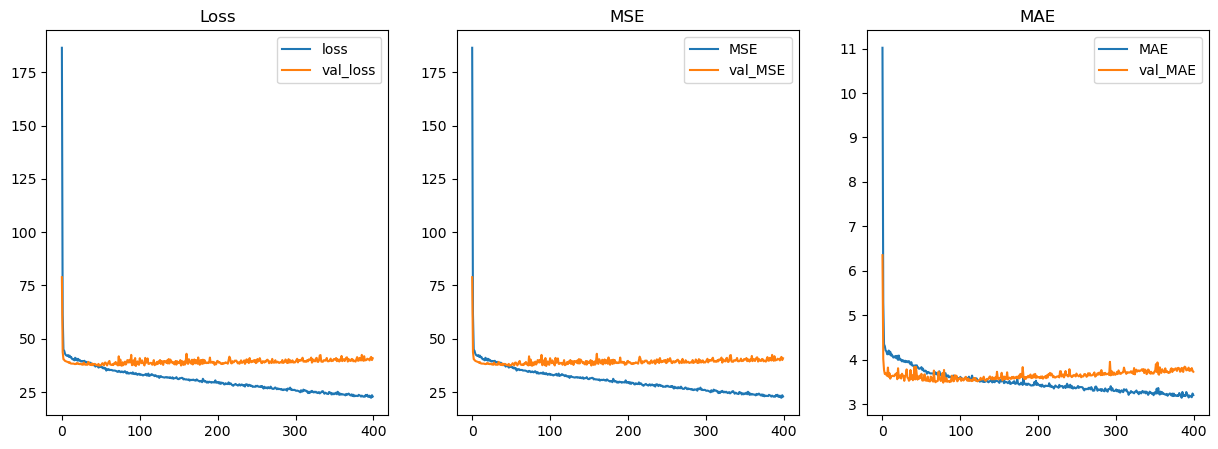

In [15]:
plt.rcParams['figure.figsize'] = (15,5)
plt.subplot(1,3,1)
plt.plot(yamnet_history.history['loss'])
plt.plot(yamnet_history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')

plt.subplot(1,3,2)
plt.plot(yamnet_history.history['MSE'])
plt.plot(yamnet_history.history['val_MSE'])
plt.legend(['MSE', 'val_MSE'])
plt.title('MSE')

plt.subplot(1,3,3)
plt.plot(yamnet_history.history['MAE'])
plt.plot(yamnet_history.history['val_MAE'])
plt.legend(['MAE', 'val_MAE'])
plt.title('MAE')

In [16]:
# test inference time
s = time.time()
filename = '/kaggle/input/nuaih-age-capturing-from-speech-signals/Age_Through_Speech/Age_Through_Speech/one_and_multiple/S_01_4001_VE.wav'
wav, sr = librosa.load(filename, sr=48000)
wav = nr.reduce_noise(wav, sr)
wav = librosa.resample(wav, orig_sr=sr, target_sr=16000)
_, yamnet_embedd, _ = yamnet_model(wav)
prediction = cnn_model(yamnet_embedd)
e = time.time()

print(yamnet_embedd.shape)
print( int(mode(np.round(prediction.numpy()))[0][0][0]) )
print("Inference + preprocessing time in sec: ", e-s)

(4, 1024)
20
Inference + preprocessing time in sec:  0.11943483352661133


In [17]:
# Try huber loss function
huber_cnn_model = create_yamnet_cnn()
huber_cnn_model.compile(optimizer='adam', loss='huber', metrics=['MSE', 'MAE'])
huber_cnn_history = huber_cnn_model.fit(data, labels ,batch_size=256, epochs=400, validation_split=0.1,shuffle=True, callbacks=[checkpoint])

Epoch 1/400
31/31 [==============================] - 1s 17ms/step - loss: 10.5655 - MSE: 191.4537 - MAE: 11.0561 - val_loss: 5.5323 - val_MSE: 75.2234 - val_MAE: 6.0101
Epoch 2/400
31/31 [==============================] - 0s 11ms/step - loss: 4.4670 - MSE: 56.2218 - MAE: 4.9403 - val_loss: 3.2952 - val_MSE: 42.9512 - val_MAE: 3.7600
Epoch 3/400
31/31 [==============================] - 0s 11ms/step - loss: 3.7395 - MSE: 44.9995 - MAE: 4.2102 - val_loss: 3.1733 - val_MSE: 40.6370 - val_MAE: 3.6369
Epoch 4/400
31/31 [==============================] - 0s 11ms/step - loss: 3.6424 - MSE: 43.8167 - MAE: 4.1095 - val_loss: 3.1478 - val_MSE: 41.8176 - val_MAE: 3.6106
Epoch 5/400
31/31 [==============================] - 0s 11ms/step - loss: 3.6554 - MSE: 44.2152 - MAE: 4.1251 - val_loss: 3.1254 - val_MSE: 41.2513 - val_MAE: 3.5909
Epoch 6/400
31/31 [==============================] - 0s 11ms/step - loss: 3.6200 - MSE: 43.8153 - MAE: 4.0876 - val_loss: 3.0940 - val_MSE: 40.0874 - val_MAE: 3.5579
E

Text(0.5, 1.0, 'MAE')

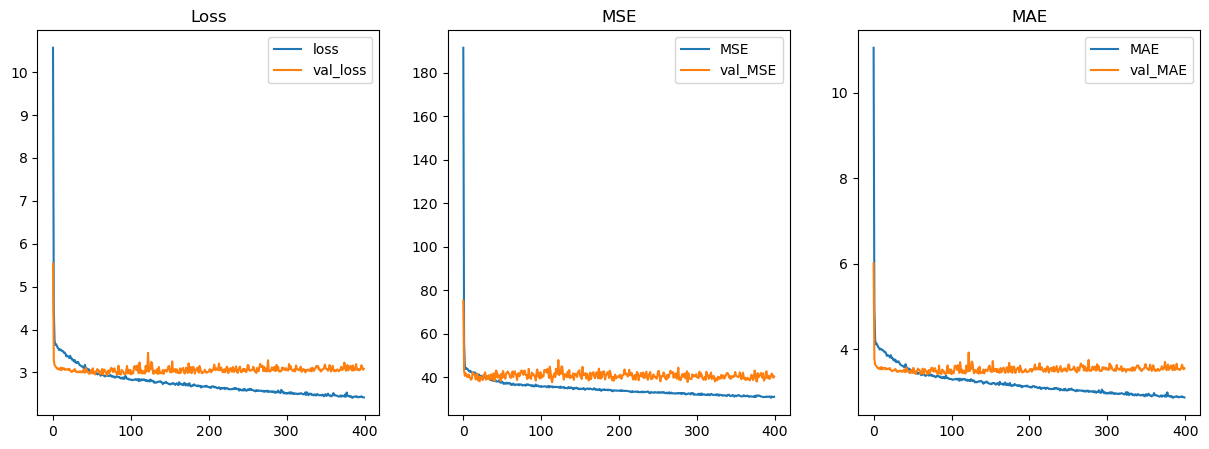

In [18]:
plt.rcParams['figure.figsize'] = (15,5)
plt.subplot(1,3,1)
plt.plot(huber_cnn_history.history['loss'])
plt.plot(huber_cnn_history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')

plt.subplot(1,3,2)
plt.plot(huber_cnn_history.history['MSE'])
plt.plot(huber_cnn_history.history['val_MSE'])
plt.legend(['MSE', 'val_MSE'])
plt.title('MSE')

plt.subplot(1,3,3)
plt.plot(huber_cnn_history.history['MAE'])
plt.plot(huber_cnn_history.history['val_MAE'])
plt.legend(['MAE', 'val_MAE'])
plt.title('MAE')

# Solve the imbalanced data problem using oversampling with SMOTE

In [19]:
oversample = SMOTE()
X, y = oversample.fit_resample(data, labels)

In [20]:
print('Before oversampling')
print(data.shape, labels.shape)
print('Before oversampling')
print(X.shape, y.shape)

Before oversampling
(8566, 1024) (8566,)
Before oversampling
(43857, 1024) (43857,)


In [21]:
smote_cnn_model = create_yamnet_cnn()
smote_cnn_model.compile(optimizer='adam', loss='MSE', metrics=['MSE', 'MAE'])
smote_cnn_history = smote_cnn_model.fit(X, y, batch_size=256, epochs=400, validation_split=0.1, callbacks=[checkpoint])

Epoch 1/400
155/155 [==============================] - 3s 16ms/step - loss: 199.8433 - MSE: 199.8433 - MAE: 10.9960 - val_loss: 928.7706 - val_MSE: 928.7706 - val_MAE: 30.1570
Epoch 2/400
155/155 [==============================] - 2s 10ms/step - loss: 99.7487 - MSE: 99.7487 - MAE: 8.1153 - val_loss: 914.4751 - val_MSE: 914.4751 - val_MAE: 29.9121
Epoch 3/400
155/155 [==============================] - 2s 11ms/step - loss: 92.9187 - MSE: 92.9187 - MAE: 7.7815 - val_loss: 925.8373 - val_MSE: 925.8373 - val_MAE: 30.0615
Epoch 4/400
155/155 [==============================] - 2s 15ms/step - loss: 88.7569 - MSE: 88.7569 - MAE: 7.5672 - val_loss: 936.3289 - val_MSE: 936.3289 - val_MAE: 30.2083
Epoch 5/400
155/155 [==============================] - 2s 10ms/step - loss: 85.1714 - MSE: 85.1714 - MAE: 7.3701 - val_loss: 923.3808 - val_MSE: 923.3808 - val_MAE: 29.9890
Epoch 6/400
155/155 [==============================] - 2s 15ms/step - loss: 82.2555 - MSE: 82.2555 - MAE: 7.2420 - val_loss: 951.696

Text(0.5, 1.0, 'MAE')

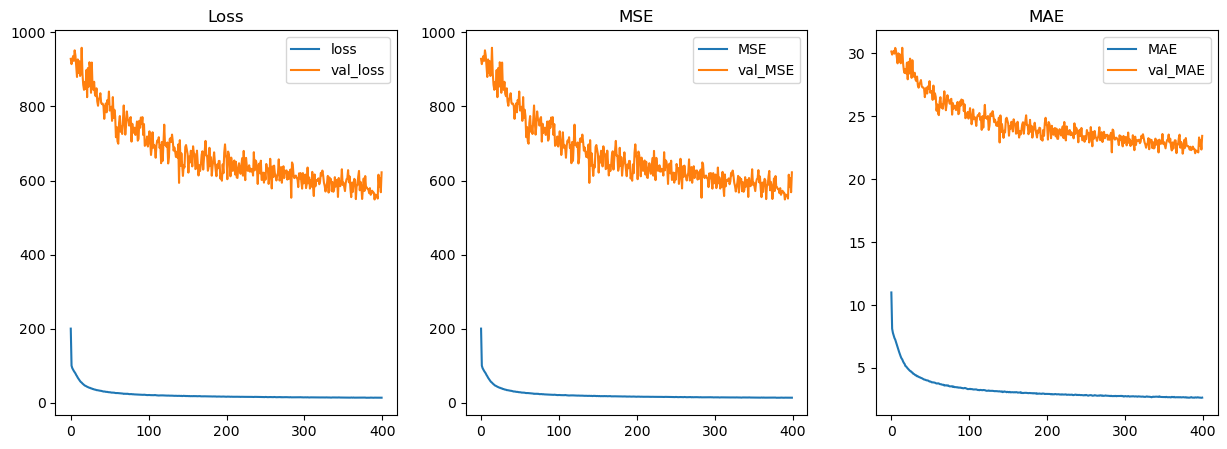

In [22]:
plt.rcParams['figure.figsize'] = (15,5)
plt.subplot(1,3,1)
plt.plot(smote_cnn_history.history['loss'])
plt.plot(smote_cnn_history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')

plt.subplot(1,3,2)
plt.plot(smote_cnn_history.history['MSE'])
plt.plot(smote_cnn_history.history['val_MSE'])
plt.legend(['MSE', 'val_MSE'])
plt.title('MSE')

plt.subplot(1,3,3)
plt.plot(smote_cnn_history.history['MAE'])
plt.plot(smote_cnn_history.history['val_MAE'])
plt.legend(['MAE', 'val_MAE'])
plt.title('MAE')